# Time Series

## Intro: what is a Time Series?
A time series is a sequence of data points collected or recorded over a period of time. It consists of a series of observations or measurements taken at regular intervals, such as seconds, minutes, hours, days, months, or years. The primary characteristic of time series data is the temporal ordering of the observations, where the values are recorded in a chronological sequence. This temporal aspect makes time series analysis unique and different from other types of data analysis. By analyzing patterns, trends, and relationships within the data, time series analysis aims to uncover useful information, make predictions, or derive insights about the underlying process that generated the data.

## Why are standard ML tools not sufficient?

- Standard machine learning algorithms:
 1. often assume that data points are independent and identically distributed, which is not the case in time series data. 
 2. typically work with fixed-length feature vectors and may not handle the dynamic nature of time series data. Custom feature engineering techniques specific to time series data are often needed.
 3. assume that the statistical properties of the data remain constant, which may not be valid for time series analysis. 
 4. Standard machine learning algorithms may not automatically capture seasonality without specific preprocessing or modeling techniques tailored to time series data.
 5.  Standard machine learning algorithms may not handle autocorrelation well and may assume independence among data points.
 6. While standard machine learning algorithms can make predictions, they may not explicitly consider the time-dependent nature of the data and may not provide accurate forecasts without specialized time series forecasting techniques.

In [113]:
import pandas as pd
import numpy as np

In [114]:
df = pd.read_csv('AusAntidiabeticDrug.csv')

df.rename(columns={'ds':'date','y':'value'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.head()

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


<AxesSubplot:xlabel='date'>

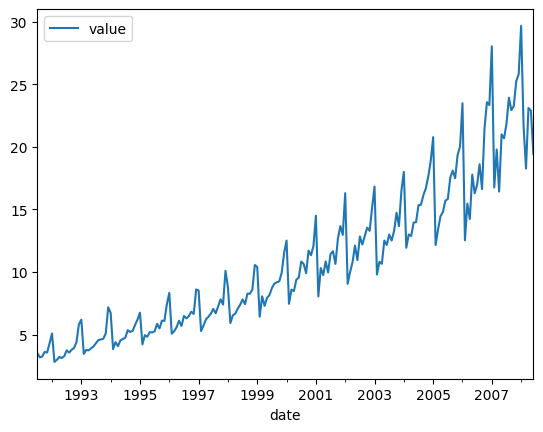

In [115]:
df.plot()

In [116]:
y = df['value']
# X = only information available = past y values

Each row/observation is X[t] = [y[t-1], y[t-2], ....]

⚠️ train_test_split

In [117]:
# Let's keep the last 40% of the values out for testing purposes
# and keep the first 60% for the training 
train_size = 0.6
index = round(train_size*df.shape[0])

df_train = df.iloc[:index] # first 60%
df_test = df.iloc[index:] # last 40%

## 2.1 Predict NEXT datapoint (1-month horizon)

Baseline (simplest model)
- 1 feature only: X[t] = y[t-1]
- Predict the previous value!

In [118]:
y_pred = df_test.shift(1)
y_pred

,value
date,
2001-09-01,NaN
2001-10-01,10.647060
2001-11-01,12.652134
2001-12-01,13.674466
2002-01-01,12.965735
...,...
2008-02-01,29.665356
2008-03-01,21.654285
2008-04-01,18.264945


In [119]:
from sklearn.metrics import r2_score

y_pred = df_test.shift(1).dropna()
y_true = df_test[1:]

print(f"R2: {r2_score(y_true, y_pred)}")

R2: 0.5069517261286796


**Linear model with 12 autoregressive features**

**Let's build our dataset X with 12 autoregressive features**

In [120]:
df2 = df.copy(); df2_train = df_train.copy(); df2_test = df_test.copy()

for i in range(1, 13):
    df2_train[f't - {i}'] = df_train['value'].shift(i)
    df2_test[f't - {i}'] = df_test['value'].shift(i)

df2_train.dropna(inplace=True)
df2_test.dropna(inplace=True)

df2_train.head()

,value,t - 1,t - 2,t - 3,t - 4,t - 5,t - 6,t - 7,t - 8,t - 9,t - 10,t - 11,t - 12
date,,,,,,,,,,,,,
1992-07-01,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003,3.252221,3.180891,3.526591
1992-08-01,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003,3.252221,3.180891
1992-09-01,3.777202,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003,3.252221
1992-10-01,3.924490,3.777202,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869,3.611003
1992-11-01,4.386531,3.924490,3.777202,3.558776,3.737851,3.270523,3.127578,3.204780,2.985811,2.814520,5.088335,4.306371,3.565869


In [121]:
# Train Test Split
X2_train = df2_train.drop(columns = ['value'])
y2_train = df2_train['value']
X2_test = df2_test.drop(columns = ['value'])
y2_test = df2_test['value']

print(X2_train.shape, y2_train.shape, X2_test.shape,y2_test.shape)

(110, 12) (110,) (70, 12) (70,)


R2:  0.8580874548863759


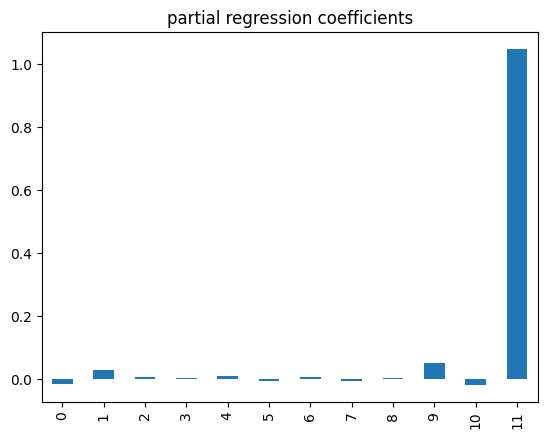

In [122]:
# Predict and measure R2
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

model = LinearRegression()
model = model.fit(X2_train, y2_train)

print('R2: ', r2_score(y2_test, model.predict(X2_test)))
pd.Series(model.coef_).plot(kind='bar')
plt.title('partial regression coefficients');

## 2.2 Predict a longer time horizon?

We need to train one model per forecast horizon!

## Decomposition

Most Time Series can be decomposed into several components:

- Trend
- Seasonal (calendar)/Periodic (non-calendar)
- Irregularities

These components can be additive or multiplicative

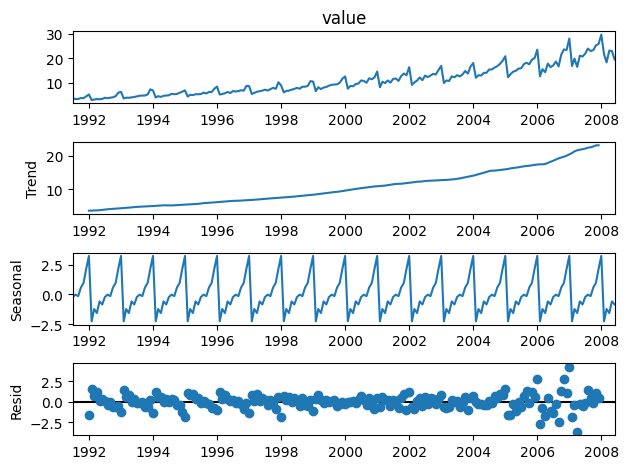

In [123]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df['value'], model='additive')
result_add.plot();

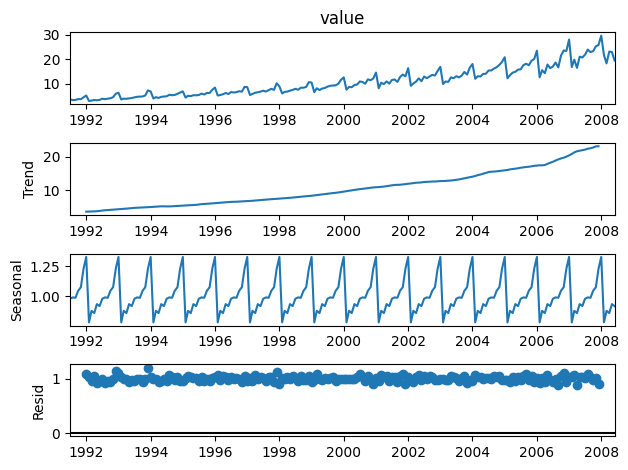

In [124]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(df['value'], model='multiplicative')
result_mul.plot();

In [126]:
print(df.head(1).value)
print(result_add.trend[0] + result_add.seasonal[0] + result_add.resid[0])
print(result_mul.trend[0] * result_mul.seasonal[0] * result_mul.resid[0])

date
1991-07-01    3.526591
Name: value, dtype: float64
nan
nan


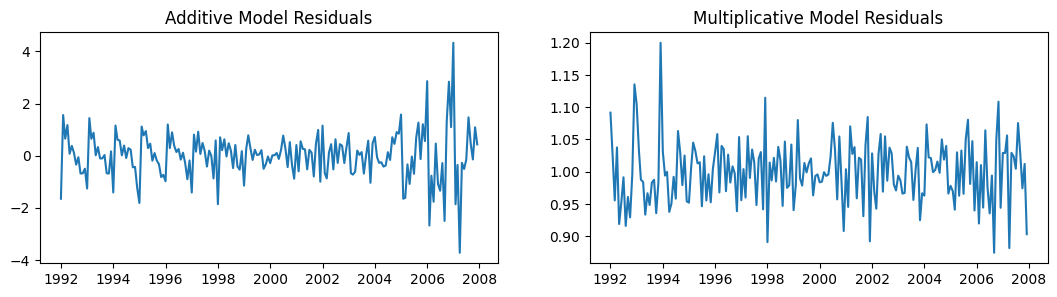

In [127]:
# Plot the residuals with "result_add.resid" to decide
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.plot(result_add.resid); ax1.set_title("Additive Model Residuals")
ax2.plot(result_mul.resid); ax2.set_title("Multiplicative Model Residuals");

☝️ Multiplicative residuals seem to have "less notion of time" ➔ better

🤔 Why? Models work best when forecasting TS that do not exhibit meaningful statistical changes over time (so that we can capture these statistical properties and project/extrapolate them into the future)

In time series we call this stationarity.

### ✅ Most statistical forecasting methods are designed to work on stationary Time Series
Convert a non-stationary TS to stationary

Forecast stationary TS by extrapolating stationary properties

Reintroduce seasonality and the rest

## Stationarity

When is a TS considered stationary?

👉 When time does not influence the statistical properties of a TS dataset, such as:

mean
variance
autocorrelation (covariance with its lagged terms)

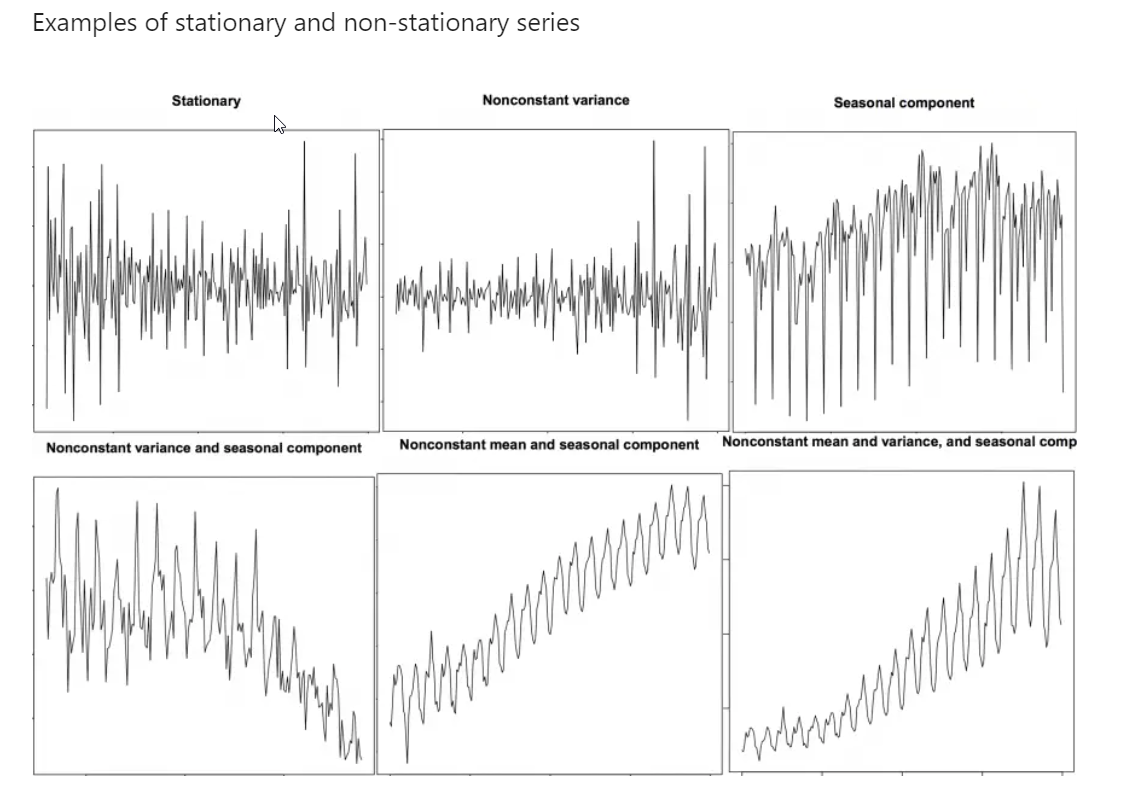

Stationary TS still contain a lot of information!

When analyzing stationary data, distribution is affected only by the size of the time window, not the location of a time window

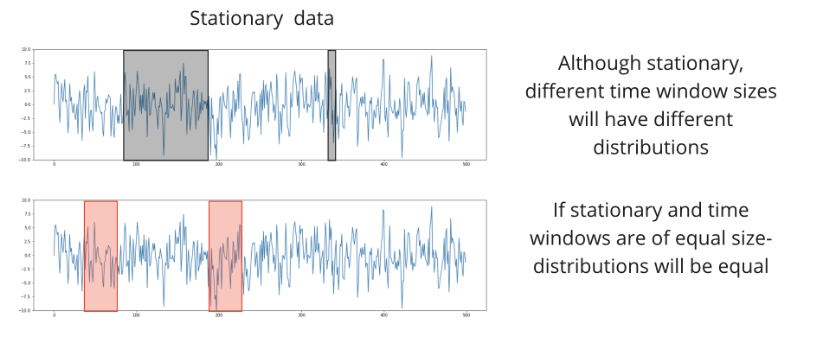

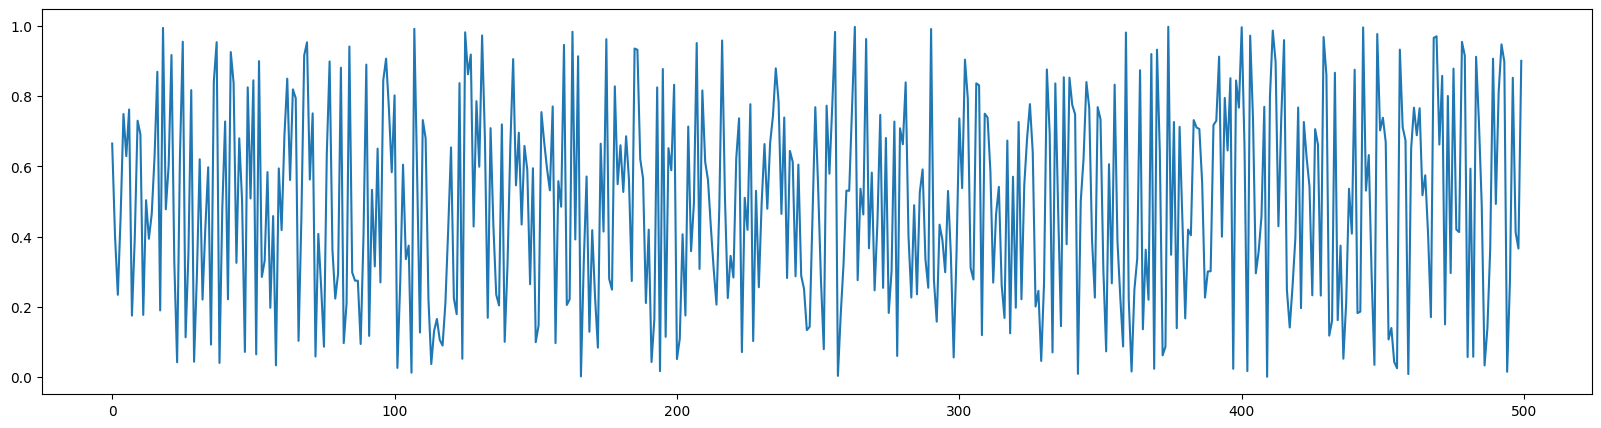

In [128]:
# White noise has no information to extract!
import scipy 

plt.figure(figsize=(20,5));
plt.plot(np.arange(500), [scipy.stats.uniform().rvs() for i in np.arange(500)]);

How do we test for stationarity?

- Visually
- Calculate (mean, variance, and autocorrelation) in various intervals
- Augmented Dickey Fuller - ADF Test (p-values)

### Augmented Dickey Fuller - ADF (Hypothesis Test)

ADF tests the following null hypothesis:

H0: The series is not-stationary

A `p-value` close to 0 (e.g. p < 0.05) **indicates stationarity**

In [129]:
from statsmodels.tsa.stattools import adfuller

adfuller(df.value)[1]  # p-value

1.0

In [130]:
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multiplicative resid: ', adfuller(result_mul.resid.dropna())[1])

additive resid:  0.0002852221054738013
multiplicative resid:  1.7472595795331867e-07


Different ways to achieve stationarity
Decomposition, e.g. 

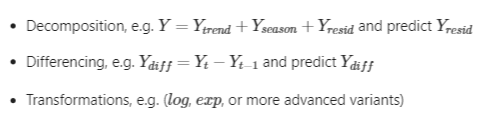<br>
or any combination of these three ways!

## Autocorrelation

Measures the correlation between the time series Y(t)a lagged version of itself Y(t−i)

**Plot each correlation in an autocorrelation graph (ACF) below**

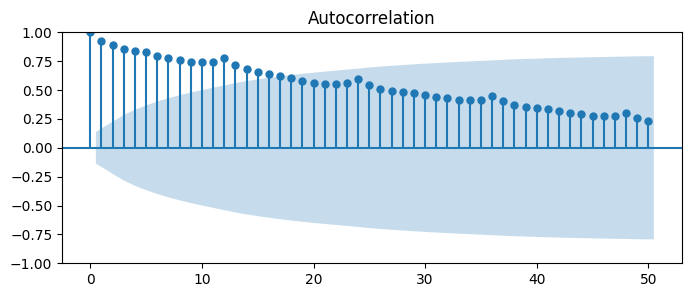

In [131]:
fig, ax = plt.subplots(1,1, figsize=(8,3))
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.value, lags=50, ax=ax)
plt.show()

The blue cone represents a confidence interval (the default is 95%)

Peak inside of cone ➔ not statistically significant

🧐 What do the peaks represent?

Peaks every 12 months indicate the seasonal nature of the data - for example, the value in March 1994 will have a relatively strong correlation with the value in March 1993!

ACF peaks typically decreases slowly: the further back in time you look, the less likely it is that that shift will have an influence

AR (Auto regresssive processes)

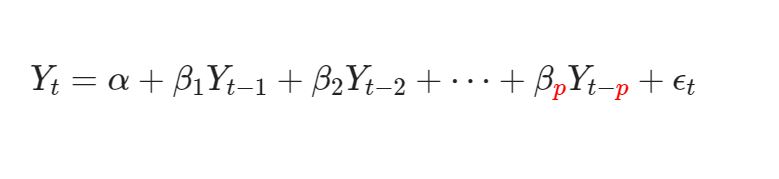<br>

This is a multivariate linear regression formula
The partial correlation coefficients 
β
i
 should give us clues about the isolated influence of specific time lags!

**We can plot each βi in a PACF graph (Partial ACF)**

/home/tatchiwiggers/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


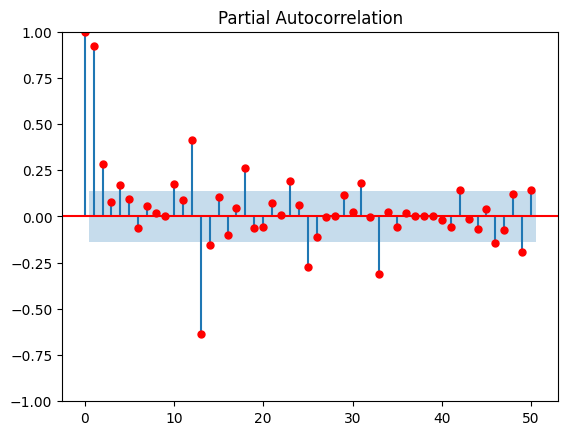

In [132]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df.value, lags=50, c='r');

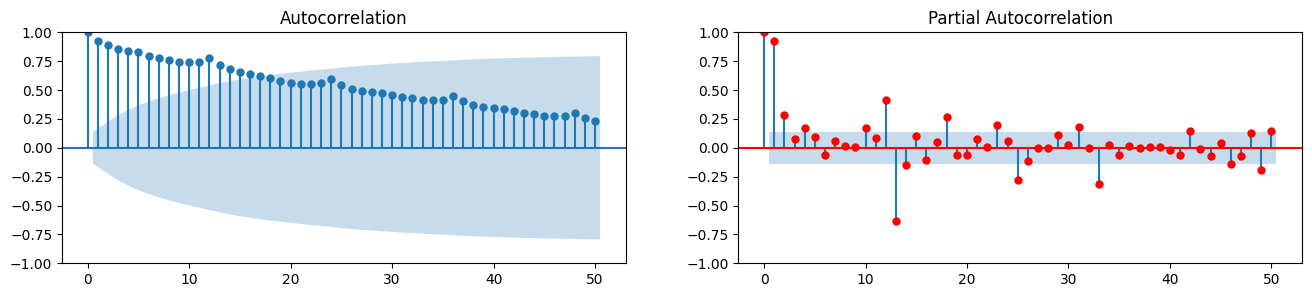

In [133]:
fig, axes = plt.subplots(1,2, figsize=(16,3))

plot_acf(df.value, lags=50, ax=axes[0]);
plot_pacf(df.value, lags=50, ax=axes[1], color='r');

ACF is simply the correlation of the series with itself

slow exponential decrease if X(t) is always correlated with X(t−1), then it is also correlated with X(t−2)PACF is even more informative it removes intermediary correlations


👉 Annual seasonality is confirmed (peaks at lag = 12)

**Let's "synthetize" a first order AR(1) process:**

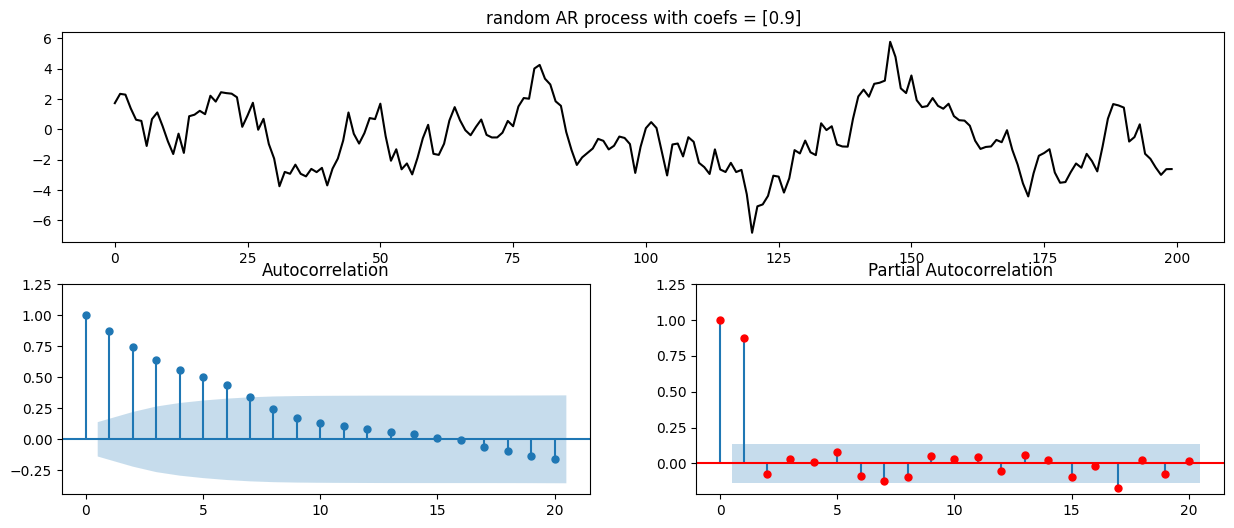

In [134]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
ar_terms = np.array([1, -0.9])
ma_terms = np.array([1])
ma_process = ArmaProcess(ar=ar_terms, ma=ma_terms)
simulated_data = ma_process.generate_sample(nsample=200)

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title(f'random AR process with coefs = {-ar_terms[1:]}')
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)
ax1.plot(simulated_data, color='black')
plot_acf(simulated_data, lags=20, auto_ylims=True,ax=ax2);
plot_pacf(simulated_data, lags=20, method='ywm', auto_ylims=True, ax=ax3, color='r');

☝️ AR process "looks" random but is not! Autoregression makes it "stickier" than white noise

☝️ We can "capture" information about the "order" p of AR process in the PACF plot by counting the number of non-null coefs in red (always excludes first coef of order 0)

## MA (Moving Average processes)

Another type of model should be considered for a stationary time series...

What about modeling a linear combination of consecutive random errors ϵ ?

Does not depend on past Y values
Tends to stay around average value 
α
Any "random shock" will only have a very limited time effect of duration q (contrary to AR processes)

Let's plot a first order random MA(1) process

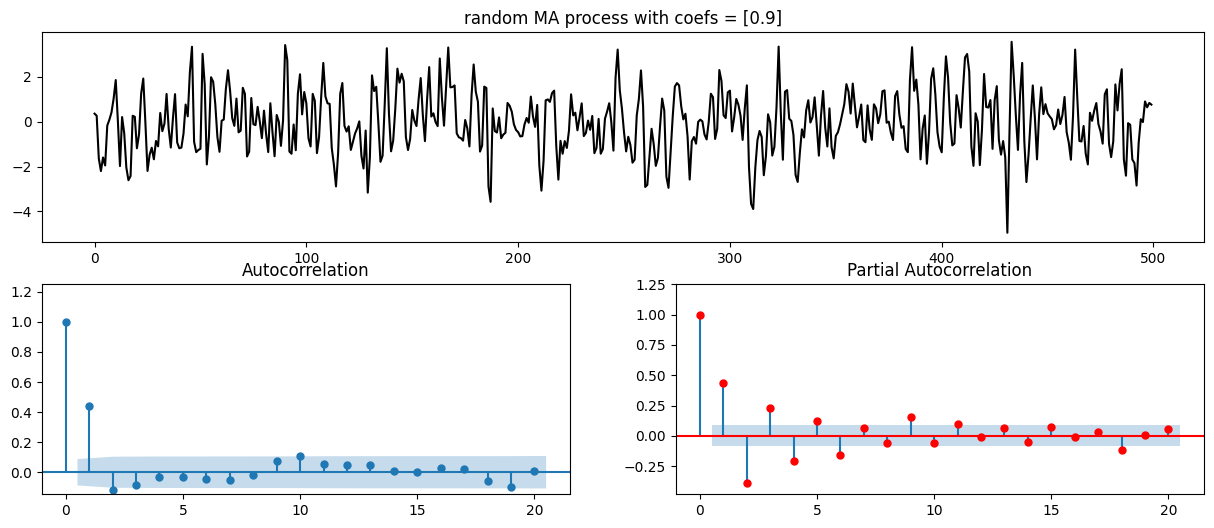

In [135]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
ar_terms = np.array([1])
ma_terms = np.array([1, 0.9])
ma_process = ArmaProcess(ar=ar_terms, ma=ma_terms)
simulated_data = ma_process.generate_sample(nsample=500)

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title(f'random MA process with coefs = {ma_terms[1:]}')
ax2 = fig.add_subplot(2,2,3)
ax3 = fig.add_subplot(2,2,4)
ax1.plot(simulated_data, color='black')
plot_acf(simulated_data, lags=20, auto_ylims=True,ax=ax2);
plot_pacf(simulated_data, lags=20, method='ywm', auto_ylims=True, ax=ax3, color='r');

☝️ MA process "look" random but are actually not!

☝️ We can deduce information about the "order" q of the MA process by counting the number of non-null coefs in our ACF

## ARMA (Auto Regressive Moving Average)

It's used to understand and predict future points in the series. The model specifically incorporates two parts, the autoregressive (AR) part and the moving average (MA) part.

Some real world series are actually a combination our two models!

ARMA(p,q)as a linear combination of p lags of Yplus a linear combination of q lagged errors

Hyperparameters p & qp expresses how many lags we want to incorporate into ARq expresses how many lags we want to incorporate into MA

🧐 How do we know how many lags to use?

Count the number of lags before the values drop below the confidence levels Note that the first lag is ignored, as it represents AC/PAC between yt and itself

We use the PACF plot to calculate the value for p = 1

<AxesSubplot:xlabel='date'>

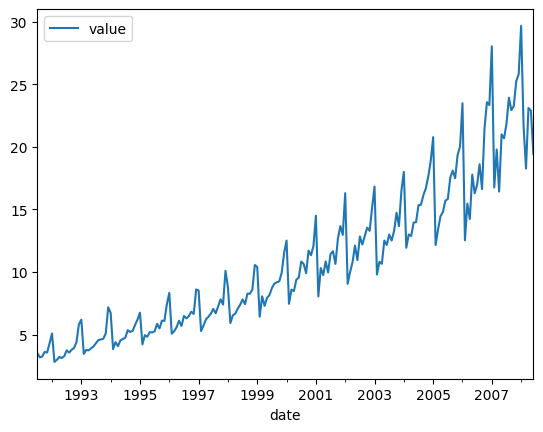

In [136]:
df.plot()

## ARIMA
(Auto Regressive Integrated Moving Average)

It is designed to capture and forecast patterns in time series data, which is data collected over regular intervals of time (e.g., daily, monthly, quarterly).

The ARIMA model combines three key components: autoregression (AR), differencing (I), and moving average (MA).

In [137]:
non_differenced_data = pd.Series([1, 4, 9, 16, 25, 36])
differenced_1 = non_differenced_data.diff()
print(differenced_1)

0     NaN
1     3.0
2     5.0
3     7.0
4     9.0
5    11.0
dtype: float64


**We should keep differencing until our data gets stationary**

In [138]:
print(differenced_1.diff())

0    NaN
1    NaN
2    2.0
3    2.0
4    2.0
5    2.0
dtype: float64


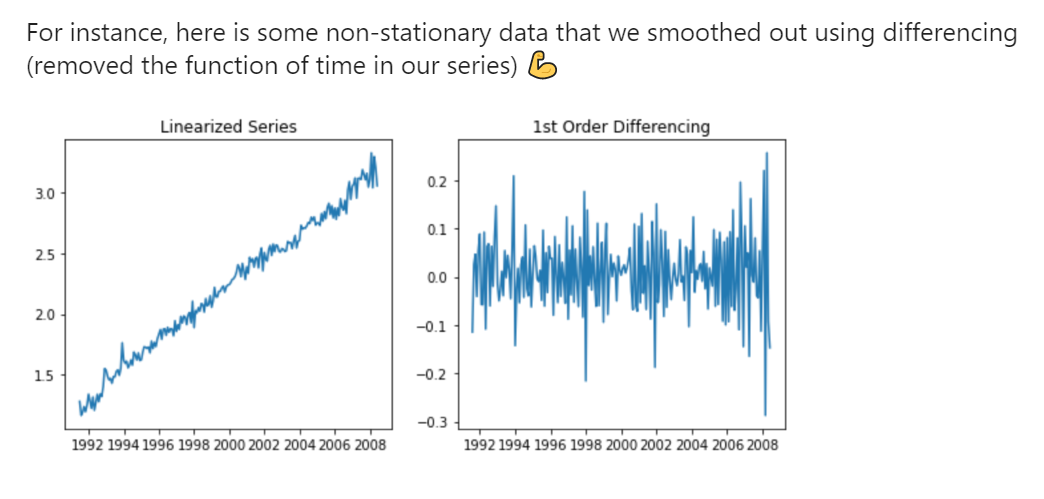

The AR process is simply a linear combination of p lags 
- a one time "shock" will propagate far into the future 
- not necessarily stationary

The MA process is a linear combination of q "random shocks"

- any "shock" will have a limited time effect
- always stationary

The I: differencing predicts Y(d) instead of Y

- Differentiate until stationary
- 💡 differencing tends to turn AR processes into MA ones
- An GDP growth "shock" may not propagate long term but a "GDP shock" will !

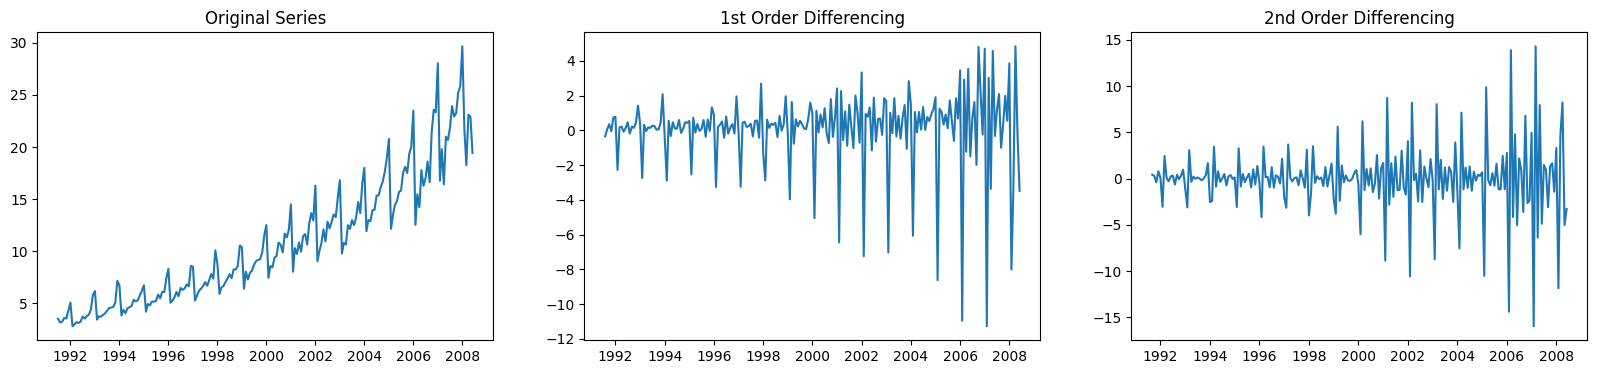

In [139]:
zero_diff = df.value
first_order_diff = df.value.diff(1)
second_order_diff = df.value.diff(1).diff(1)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');

❌ Not stationary: seasonality is still obviously present<br>
❌ Cannot apply ARIMA directly (we will see SARIMA later)

👉 We need to de-seasonalize our Time Series first, using our decomposition tool

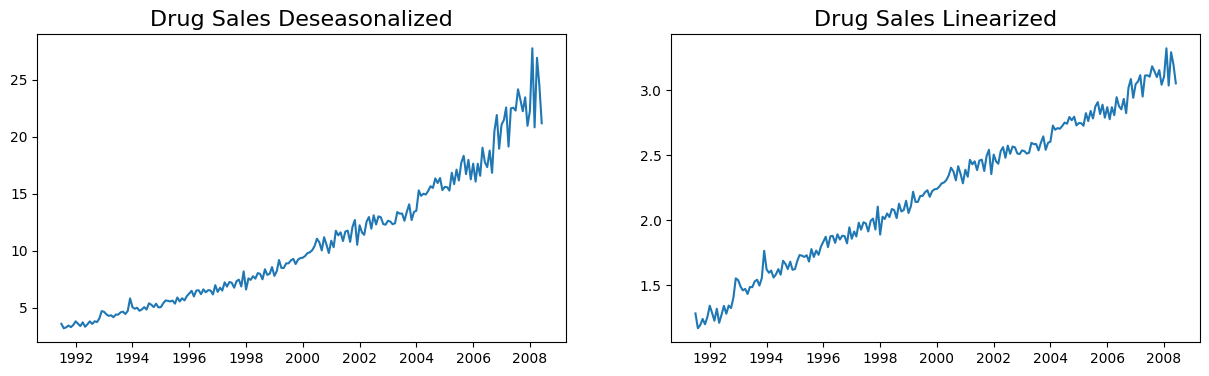

In [140]:
# Let's remove seasons
df['deseasonalized'] = df.value.values/result_mul.seasonal

plt.figure(figsize=(15,4)); plt.subplot(1,2,1); plt.plot(df.deseasonalized);
plt.title('Drug Sales Deseasonalized', fontsize=16);

# Also remove exponential trend 
df['linearized'] = np.log(df['deseasonalized'])

plt.subplot(1,2,2); plt.plot(df['linearized'])
plt.title('Drug Sales Linearized', fontsize=16);

In [141]:
result_add.resid

date
1991-07-01   NaN
1991-08-01   NaN
1991-09-01   NaN
1991-10-01   NaN
1991-11-01   NaN
              ..
2008-02-01   NaN
2008-03-01   NaN
2008-04-01   NaN
2008-05-01   NaN
2008-06-01   NaN
Name: resid, Length: 204, dtype: float64

**Let's re-run our differencing analysis on this new linearized Time Series**

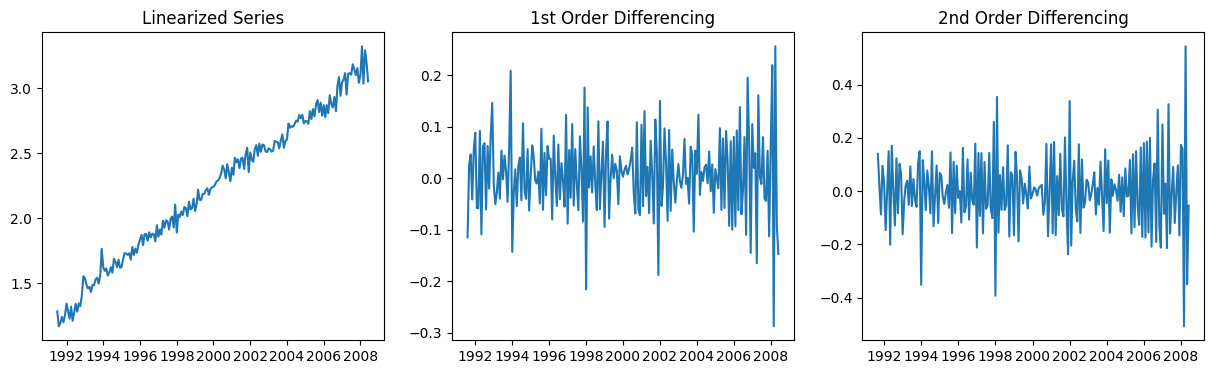

In [142]:
# Let's difference this and look at the ACFs
fig, axes = plt.subplots(1, 3,figsize=(15,4))

axes[0].plot(df['linearized']); axes[0].set_title('Linearized Series')
# 1st Differencing
y_diff = df['linearized'].diff().dropna()
axes[1].plot(y_diff); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
y_diff_diff = df['linearized'].diff().diff().dropna()
axes[2].plot(y_diff_diff); axes[2].set_title('2nd Order Differencing');

In [143]:
# check with ADF Test for stationarity
print('p-value zero-diff: ', adfuller(df['linearized'])[1])
print('p-value first-diff: ', adfuller(df['linearized'].diff().dropna())[1])
print('p-value second-diff: ', adfuller(df['linearized'].diff().diff().dropna())[1])

p-value zero-diff:  0.7134623265852269
p-value first-diff:  1.0092820652731903e-09
p-value second-diff:  1.318178239864266e-12


No need to over-difference

☝️ We should select d=1

Usually, 1-diff is enough! If not, you might have exponential behavior and might want to use a log transformation instead! Alternatively, we can de-trend and work with the de-trended series without differencing.

**Another way to determine how many orders of differencing to apply**

In [144]:
# automatically estimate differencing term
from pmdarima.arima.utils import ndiffs
ndiffs(df['linearized'])

1

## Finding the hyperparameters p&q

/home/tatchiwiggers/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


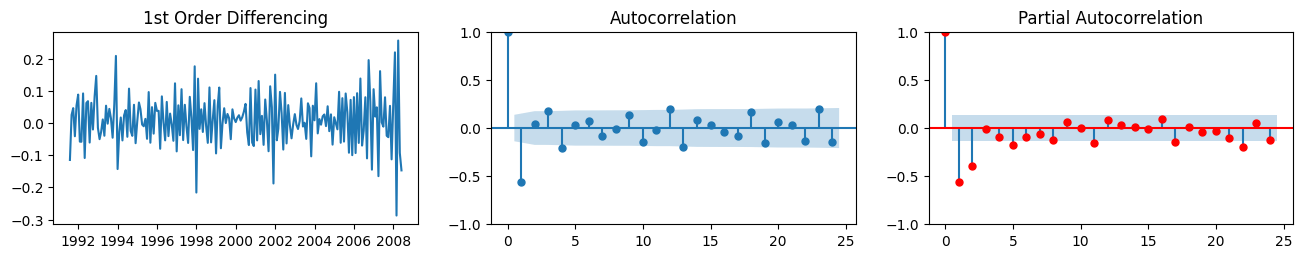

In [145]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(y_diff); axes[0].set_title('1st Order Differencing')
plot_acf(y_diff, ax=axes[1]);
plot_pacf(y_diff, ax=axes[2], c='r');

☝️ PACF ➔ p = 2<br>
☝️ ACF ➔ q = 1

☝️ More nuanced rules can be applied to hyperparameter tuning

Use the Box-Jenkins method

IMPORTANT: more than one model might explain your data.
📚 More details can be found here and here

When in doubt, choose the simpler model!

In [146]:
# from statsmodels.tsa.arima_model import ARIMA #statsmodels 0.11
from statsmodels.tsa.arima.model import ARIMA  #statsmodels 0.12+

arima = ARIMA(df['linearized'], order=(2, 1, 1), trend='t')
arima = arima.fit()

/home/tatchiwiggers/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tatchiwiggers/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tatchiwiggers/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [147]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             linearized   No. Observations:                  204
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 291.326
Date:                Wed, 07 Jun 2023   AIC                           -572.651
Time:                        09:17:25   BIC                           -556.085
Sample:                    07-01-1991   HQIC                          -565.949
                         - 06-01-2008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0097      0.001     11.610      0.000       0.008       0.011
ar.L1         -0.1420      0.095     -1.491      0.136      -0.329       0.045
ar.L2          0.0290      0.088      0.329      0.742      -0.144       0.202
ma.L1         -0.7891      0.078    -10.162      0.000      -0.941      -0.637
sigma2         0.0033      0.000     12.309      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                26.46
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                             0.47
Prob(H) (two-sided):                  0.25   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

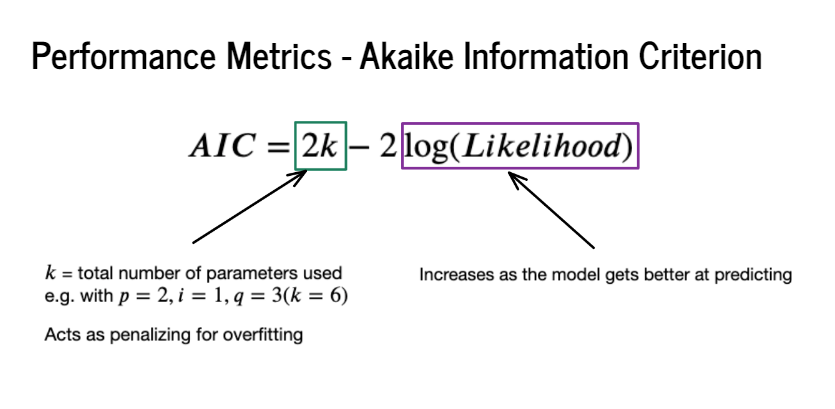

**We can also use auto_arima to GridSearch the hyperparameters p, d, q 🥳**

In [148]:
import pmdarima as pm
smodel = pm.auto_arima(df['linearized'],
                       start_p=1, max_p=2,
                       start_q=1, max_q=2,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-555.440, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-453.201, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-527.228, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-533.804, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-453.201, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-560.953, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-562.744, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-562.744, Time=0.05 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 0.697 seconds


⚠️ Several models have similar AIC values around -560.

Any of them might be the "true" underlying process

👉 When in doubt, pick the simplest model `ARIMA(p=2,d=1,q=0)`

## Evaluate Performance

Use plot_predict() to glance at our predictions

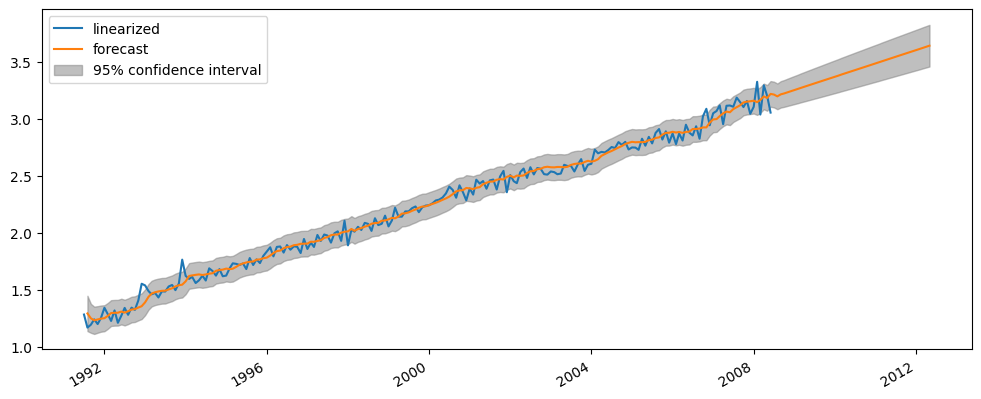

In [149]:
from statsmodels.graphics.tsaplots import plot_predict

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(df['linearized'], label='linearized')
plot_predict(arima, start=1, end=250, ax=axs);

Use .forecast() to simply access forecasts<br>
Use .get_forecast() to access forecasts and confidence intervals

In [150]:
# Create a correct train_test_split to predict the last 50 points
train = df['linearized'][0:150]
test = df['linearized'][150:]

# Build model
arima = ARIMA(train, order=(2, 1, 0), trend='t')  
arima = arima.fit()

## Forecast
# Forecast values
forecast = arima.forecast(len(test), alpha=0.05)  # 95% confidence

# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

/home/tatchiwiggers/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tatchiwiggers/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tatchiwiggers/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [151]:
# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

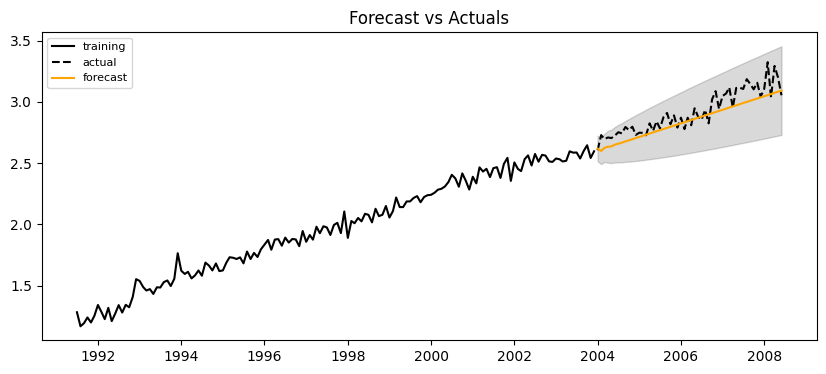

In [152]:
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])

⚠️Remember, this wasn't our original Time Series!

This is the linearized version, we extracted the seasonal and exponential components.

Let's add them back in

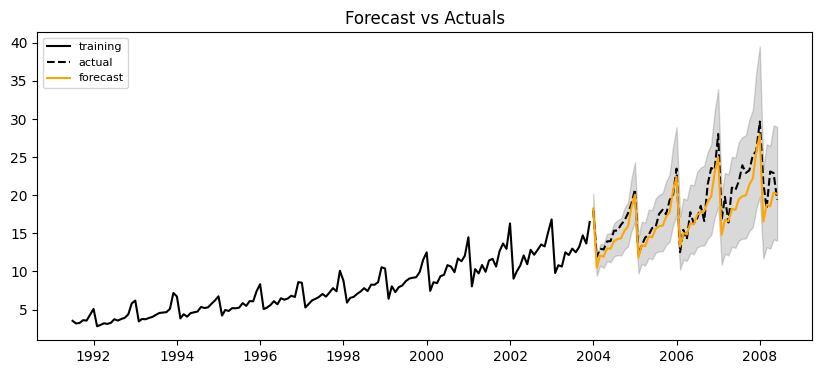

In [153]:
# Re-compose back to initial TS

forecast_recons = np.exp(forecast) * result_mul.seasonal[150:]
train_recons = np.exp(train) * result_mul.seasonal[0:150]
test_recons = np.exp(test) * result_mul.seasonal[150:]
lower_recons = np.exp(confidence_int)[:, 0] * result_mul.seasonal[150:]
upper_recons = np.exp(confidence_int)[:, 1] * result_mul.seasonal[150:]

# Plot
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)

**Check residuals for inference validity**

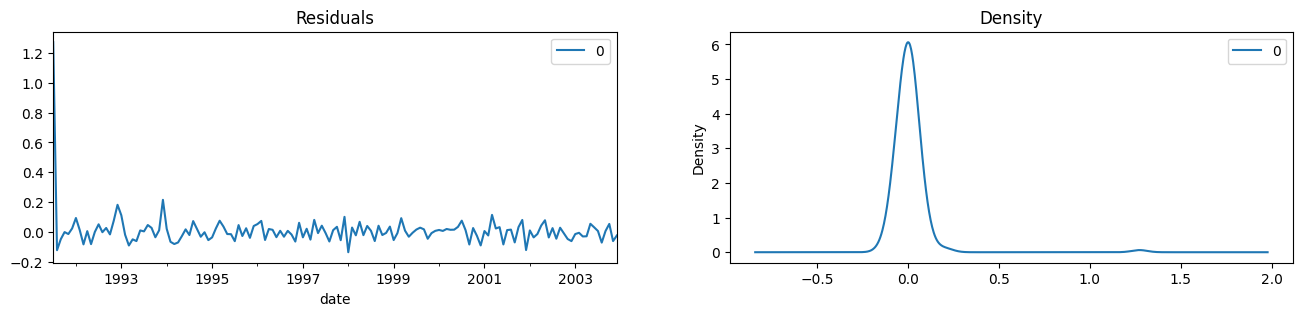

In [154]:
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

✅ Residuals of equal variance over time (i.e. homoskedastic)

✅ Approximately normally distributed

👉 We can trust our "confidence interval"

### Box Jenkins Method (details)
1. Apply transformations to make Time Series stationary (de-trending, transformations, differencing)
2. If differencing, keep track of order d of differencing; don't over-difference!
3. Confirm stationarity (visually, ACF, ADF test)
4. Plot ACF/PACF, identify likely AR and MA orders p, q.
5. Fit original (non-differenced) data with ARIMA model of order p, d, q
6. Try a few other values around these orders
7. If all models with similarly low AIC, pick the least complex one
8. Inspect residuals: if ACF and PACF show white noise (no signal left) ➔ you are done.
9. Otherwise ➔ iterate (try other transformations, change order of differencing, add/remove MA/AR terms)
10. (Optional) Compare with Auto-ARIMA output trace

##  Seasonal ARIMA (SARIMA)

Removes the need to de-seasonalize our data

Let's plot our original Time Series one more time

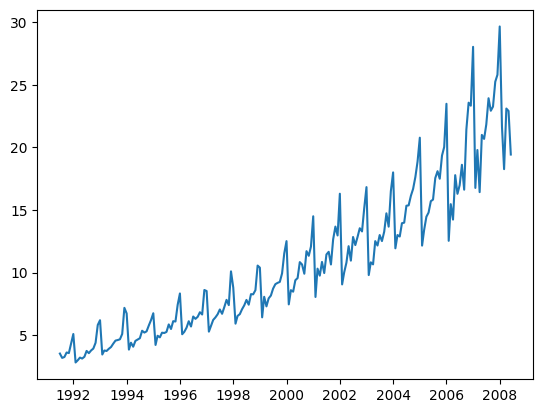

In [155]:
plt.plot(df.value);

Where are the season windows in our data?

We've identified a repeating pattern within our data. The window looks like a window of size 12

This makes sense! Yearly patterns are very common

❌ Not great for stationarity

We're going to take seasonal patterns into account by modeling at the individual lag level and at the seasonal level

Let's use our differencing as an example of modeling at different time windows.

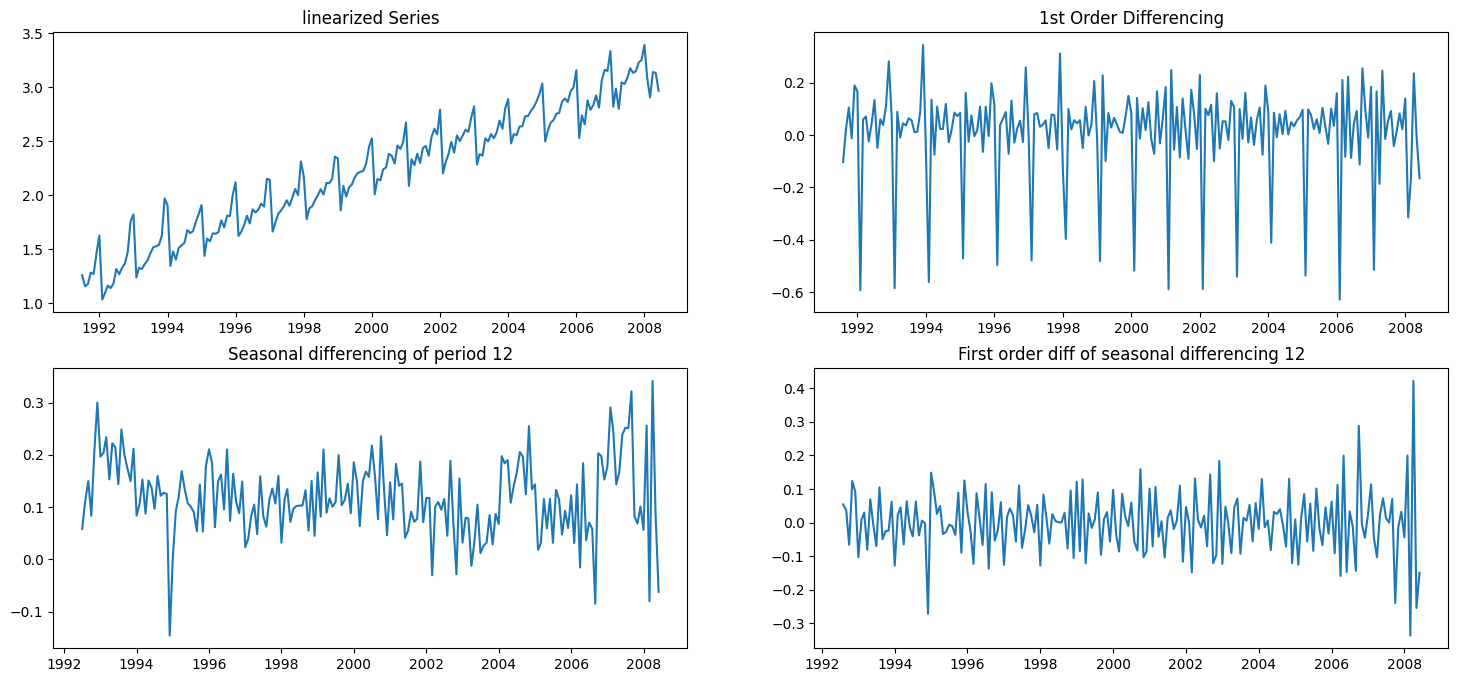

In [156]:
fig, axs = plt.subplots(2, 2, figsize=(18,8))
# keeping just log transform to stay ~ linear
df['log'] = np.log(df.value)

# linearized series
axs[0,0].plot(df.log); axs[0,0].set_title('linearized Series')

# Normal differencing
axs[0,1].plot(df.log.diff(1)); axs[0,1].set_title('1st Order Differencing')

# Seasonal differencing
axs[1,0].plot(df.log.diff(12))
axs[1,0].set_title('Seasonal differencing of period 12')

# Sesonal + Normal differencing
axs[1,1].plot(df.log.diff(12).diff(1))
axs[1,1].set_title('First order diff of seasonal differencing 12');

Just like we applied differencing at two different lag levels, we can apply the other hyperparmeters (p and q) as well!

**SARIMA has 7 hyperparameters**

SARIMA(p,d,q)(P,D,Q)[S]
p ~ AR hyperparameter for individual lag level

d ~ Integration hyperparameter for individual lag level

q ~ MA hyperparameter for individual lag level

P ~ AR hyperparameter for seasonal lag level

D ~ Integration hyperparameter for seasonal lag level

Q ~ MA hyperparameter for seasonal lag level

👉 GridSearch advised
👉 Must only choose S manually (S = 12, for annual seasonality)

In [157]:
# Create a correct Training/Test split to predict the last 50 points
train = df.log[0:150]
test = df.log[150:]

In [158]:
smodel = pm.auto_arima(train, seasonal=True, m=12, 
                       start_p=0, max_p=1, max_d=1, start_q=0, max_q=1,
                       start_P=0, max_P=2, max_D=1, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-83.662, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-85.171, Time=0.07 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=2.32 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-190.471, Time=1.09 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-315.673, Time=0.53 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=2.30 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=-326.854, Time=2.00 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=-366.782, Time=2.59 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-362.020, Time=3.1

☝️ best model found

In [160]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMAX(train, order=(0, 1, 1), seasonal_order=(2, 0, 2, 12))

/home/tatchiwiggers/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tatchiwiggers/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [161]:
# Build Model
sarima = SARIMAX(train, order=(0, 1, 1), seasonal_order=(2, 0, 2, 12))
sarima = sarima.fit(maxiter=75)

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

/home/tatchiwiggers/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tatchiwiggers/.pyenv/versions/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.91380D-01    |proj g|=  4.90088D+00


 This problem is unconstrained.



At iterate    5    f= -1.31920D+00    |proj g|=  1.64748D+00

At iterate   10    f= -1.33501D+00    |proj g|=  2.50252D+00

At iterate   15    f= -1.36721D+00    |proj g|=  3.84948D-01

At iterate   20    f= -1.36770D+00    |proj g|=  1.22453D-01

At iterate   25    f= -1.37263D+00    |proj g|=  3.34395D-01

At iterate   30    f= -1.37505D+00    |proj g|=  6.48349D-03

At iterate   35    f= -1.37616D+00    |proj g|=  1.39053D-01

At iterate   40    f= -1.38875D+00    |proj g|=  2.15791D+00

At iterate   45    f= -1.40394D+00    |proj g|=  4.74635D-01

At iterate   50    f= -1.40552D+00    |proj g|=  2.45191D-01

At iterate   55    f= -1.40570D+00    |proj g|=  6.75282D-03
  ys=-9.873E-06  -gs= 1.168E-05 BFGS update SKIPPED

At iterate   60    f= -1.40578D+00    |proj g|=  3.17195D-02

At iterate   65    f= -1.40578D+00    |proj g|=  5.81535D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored d

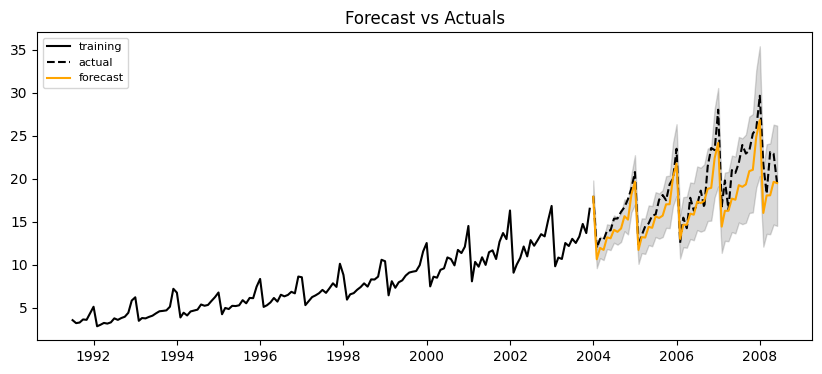

In [162]:
# Reconstruct by taking exponential
forecast_recons = pd.Series(np.exp(forecast), index=test.index)
lower_recons = np.exp(confidence_int['lower log']).values
upper_recons = np.exp(confidence_int['upper log']).values

plot_forecast(forecast_recons, np.exp(train), np.exp(test), upper = upper_recons, lower=lower_recons)

In [163]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                     log   No. Observations:                  150
Model:             SARIMAX(0, 1, 1)x(2, 0, [1, 2], 12)   Log Likelihood                 210.867
Date:                                 Wed, 07 Jun 2023   AIC                           -409.734
Time:                                         09:50:59   BIC                           -391.710
Sample:                                     07-01-1991   HQIC                          -402.411
                                          - 12-01-2003                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7952      0.063    -12.674      0.000      -0.918      -0.672
ar.S.L12       1.2083      0.058     20.799      0.000       1.094       1.322
ar.S.L24      -0.2091      0.057     -3.691      0.000      -0.320      -0.098
ma.S.L12      -0.6381      0.123     -5.172      0.000      -0.880      -0.396
ma.S.L24      -0.2547      0.099     -2.571      0.010      -0.449      -0.061
sigma2         0.0026      0.000      6.913      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                10.25
Prob(Q):                              0.79   Prob(JB):                         0.01
Heteroskedasticity (H):               0.75   Skew:                            -0.27
Prob(H) (two-sided):                  0.31   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 11) SARIMA(X) for eXogenous features

We can take advantage of two correlated Time Series by using one to predict another

Hypothesis

Lower temperatures = higher electricity demand for heating = higher electricity prices

Therefore

Using past variations of:
- market prices (endogenous variable) ⬅ itself
- external weather forecasts (exogenous variable) ⬅ external Time Series
we can then predict the price of electricity 💪

In [1]:
!pwd

/home/tatchiwiggers/code/lewagon-lectures/data-science-lectures/05-machine-learning/09-time-series
